### Libraries import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from library.synthetic_control import SyntheticControl
from library.data_generator import generate_gaussian_process_data
from library.synthetic_did import SyntheticDIDModel

plt.style.use('ggplot')

### Data generation

In [2]:
N = 10     
T = 100     
T0 = 50       
effect = -5.0 

all_series = generate_gaussian_process_data(N=N, T=T, length_scale=2.0, seed=42)

all_series[0, T0:] += effect

for i in range(1, N):
    all_series[i, :] += 2

df_list = []
for unit_idx in range(N):
    for time_idx in range(T):
        y_val = all_series[unit_idx, time_idx]
        treated_flag = (unit_idx == 0) 
        after_treatment_flag = (time_idx >= T0)
        df_list.append({
            "unit": unit_idx,
            "time": time_idx,
            "y": y_val,
            "treated": treated_flag,
            "after_treatment": after_treatment_flag
        })

data = pd.DataFrame(df_list)

### Synthetic control example

Реализуем следующую модель:

$$
\min_{\mathbf{w} \in \Delta_J} \left\| \mathbf{y}_{\text{pre}}^{\text{tr}} - \mathbf{Y}_{\text{pre}}^{\text{co}} \mathbf{w} \right\|_2^2
$$
где $\Delta_J$ обозначает $J$-мерное симплексное множество и оно удовлетворяет условию:

$$\Delta_J = \left\{ \mathbf{w} \in \mathbb{R}^{J} \,\bigg|\, w_j \ge 0, \; \sum_{j=1}^{J} w_j = 1 \right\}
$$

SC ATT: -7.0203
Веса синтетического контроля:
Индекс: 1, Значение: 0.08
Индекс: 2, Значение: 0.03
Индекс: 4, Значение: 0.07
Индекс: 5, Значение: 0.58
Индекс: 6, Значение: 0.12
Индекс: 7, Значение: 0.13


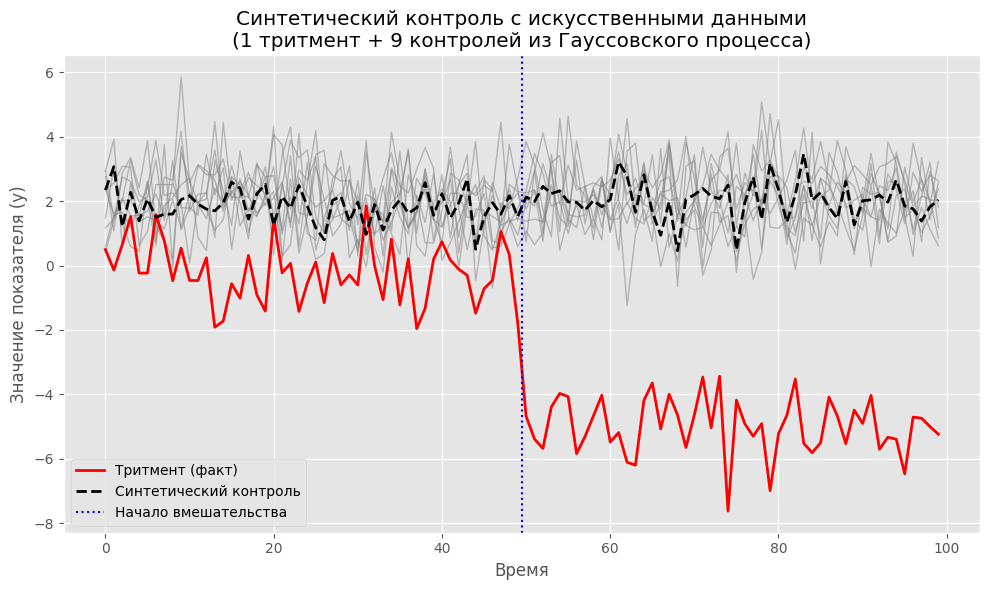

In [10]:
y_co_pre = (
    data.query("treated == False and after_treatment == False")
        .pivot(index="time", columns="unit", values="y")
)

y_tr_pre = (
    data.query("treated == True and after_treatment == False")
        .sort_values("time")["y"]
)

sc_model = SyntheticControl()
sc_model.fit(y_co_pre, y_tr_pre)
sc_weights = pd.Series(sc_model.w_, index=y_co_pre.columns, name="weights")


y_co_all = (
    data.query("treated == False")
        .pivot(index="time", columns="unit", values="y")
        .sort_index()
)

sc_full = y_co_all.dot(sc_weights) 

y_tr_all = (
    data.query("treated == True")
        .sort_values("time")["y"]
    .reset_index(drop=True) 
)  

att = y_tr_all[T0:].mean() - sc_full[T0:].mean()
print("SC ATT:", round(att, 4))

print("Веса синтетического контроля:")
sc_weights_reset = sc_weights.reset_index()
for i in range(len(sc_weights_reset)):
    value = sc_weights_reset['weights'][i]
    if value > 0:
        print(f"Индекс: {sc_weights_reset['unit'][i]}, Значение: {round(value, 2)}")

fig, ax = plt.subplots(figsize=(10, 6))

controls_all = data.query("treated == False")
for unit_idx in controls_all["unit"].unique():
    subset = controls_all.query("unit == @unit_idx").sort_values("time")
    ax.plot(subset["time"], subset["y"], color="gray", alpha=0.5, linewidth=1)

treated_all = data.query("treated == True").sort_values("time")
ax.plot(treated_all["time"], treated_all["y"], color="red", label="Тритмент (факт)", linewidth=2)

ax.plot(sc_full.index, sc_full.values, color="black", linestyle="--",
        label="Синтетический контроль", linewidth=2)

ax.axvline(T0 - 0.5, color='blue', linestyle=':', label='Начало вмешательства')

ax.set_xlabel("Время")
ax.set_ylabel("Значение показателя (y)")
ax.set_title("Синтетический контроль с искусственными данными\n(1 тритмент + 9 контролей из Гауссовского процесса)")
ax.legend()
plt.tight_layout()
plt.show()

### Synthetic DIFF and DIFF example

$$
\hat{w}^{sdid} = \underset{w}{\mathrm{argmin}} \; \left\{ \Bigl\|\bar{{y}}_{pre,tr} - \bigl({Y}_{pre,co} \, {w}_{co} + w_0\bigr)\Bigr\|_2^2 + \zeta^2\, T_{pre}\, \Bigl\|{w}_{co}\Bigr\|_2^2 \right\}
$$

при условии, что $(\sum_i w_i = 1)$ и $(w_i > 0)$ для всех $i$, а также

$$
\zeta = \bigl(N_{tr} \, T_{post}\bigr)^{1/4} \, \sigma(\Delta_{it})
$$

SDID ATT: -4.7417
Веса синтетического контроля:
Индекс: 1, Значение: 0.1
Индекс: 2, Значение: 0.13
Индекс: 3, Значение: 0.1
Индекс: 4, Значение: 0.11
Индекс: 5, Значение: 0.11
Индекс: 6, Значение: 0.12
Индекс: 7, Значение: 0.1
Индекс: 8, Значение: 0.12
Индекс: 9, Значение: 0.11


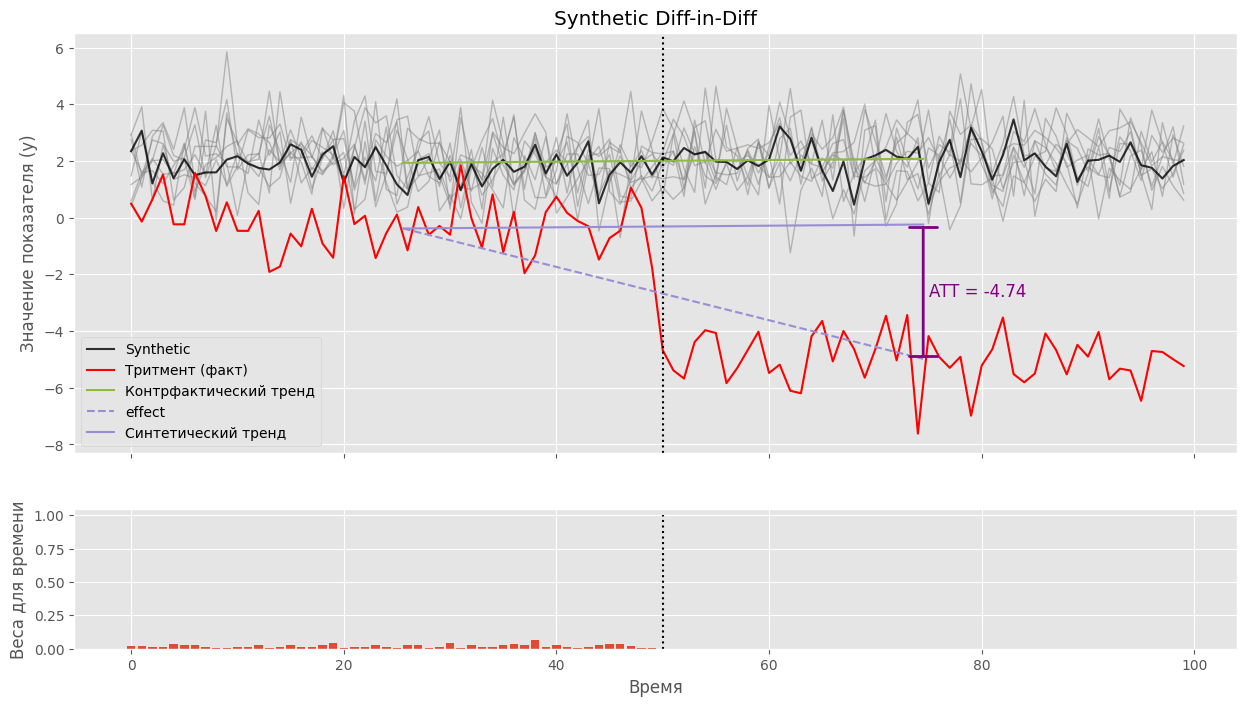

In [12]:
sc_did = y_co_all.dot(sc_weights) 
sdid_model = SyntheticDIDModel(
    data=data,
    outcome_col="y",
    period_index_col="time",
    shopno_col="unit",
    treat_col="treated",
    post_col="after_treatment"
)

att, unit_weights, time_weights, sdid_model_fit, intercept = sdid_model.synthetic_diff_in_diff()

print("SDID ATT:", round(att, 4))

print("Веса синтетического контроля:")
unit_weights_reset = unit_weights.reset_index()
for i in range(len(sc_weights_reset)):
    value = unit_weights_reset['unit_weights'][i]
    if value > 0:
        print(f"Индекс: {unit_weights_reset['unit'][i]}, Значение: {round(value, 2)}")

avg_pre_period = (time_weights * time_weights.index).sum()
avg_post_period = T0 + (data.time.max() - T0) / 2

pre_sc = sdid_model_fit.params["Intercept"]
post_sc = pre_sc + sdid_model_fit.params["after_treatment"]
pre_treat = pre_sc + sdid_model_fit.params["treated"]
post_treat = post_sc + sdid_model_fit.params["treated"] + sdid_model_fit.params["after_treatment:treated"]
sc_did_y0 = pre_treat + (post_sc - pre_sc)

plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,8), sharex=True,
                                gridspec_kw={'height_ratios': [3, 1]})

controls_all = data.query("treated == False")
for unit_idx in controls_all["unit"].unique():
    subset = controls_all.query("unit == @unit_idx").sort_values("time")
    ax1.plot(subset["time"], subset["y"], color="gray", alpha=0.5, linewidth=1)

ax1.plot(sc_did.index, sc_did, label="Synthetic", color="black", alpha=0.8)
ax1.plot(treated_all["time"], treated_all["y"], label="Тритмент (факт)", color="red")

ax1.plot([avg_pre_period, avg_post_period], [pre_sc, post_sc],
         color="C5", label='Контрфактический тренд')
ax1.plot([avg_pre_period, avg_post_period], [pre_treat, post_treat],
         color="C2", ls="dashed", label='effect')
ax1.plot([avg_pre_period, avg_post_period], [pre_treat, sc_did_y0],
         color="C2", label='Синтетический тренд')


x_bracket = avg_post_period
y_top = post_treat      
y_bottom = sc_did_y0

ax1.annotate(
    '', 
    xy=(x_bracket, y_bottom), 
    xytext=(x_bracket, y_top),
    arrowprops=dict(arrowstyle='|-|', color='purple', lw=2)
)

ax1.text(x_bracket + 0.5, (y_top + y_bottom) / 2, f"ATT = {round(att,2)}",
         color='purple', fontsize=12, va='center')

ax1.legend()
ax1.set_title("Synthetic Diff-in-Diff")
ax1.axvline(T0, color='black', linestyle=':')
ax1.set_ylabel("Значение показателя (y)")

ax2.bar(time_weights.index, time_weights)
ax2.vlines(T0, 0, 1, color="black", ls="dotted")
ax2.set_ylabel("Веса для времени")
ax2.set_xlabel("Время")

plt.show()


### Placebo variance estimation and comparison

$$
\hat{V}^{placebo}_{\tau} = B^{-1}\sum_{b=1}^B\bigg(\hat{\tau}^{(b)} - \bar{\hat{\tau}}^{(b)}\bigg)^2
$$
 
$$
\tau \in \hat{\tau}^{sdid} \pm \mathcal{z}_{\alpha/2} \sqrt{\hat{V}_{\tau}}
$$
 